In [1]:
import math

import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm

import basic_net
import dataset as MOFdata

In [2]:

def filter_data(x):
    a, b = -4000, 5000
    mid = (a+b)/2
    dif = b-a
    return np.clip(x, a, b) / dif / 2 - (mid/dif)
    # sigmoid
    # return 1/(1 + np.exp(-np.clip(x, -32, 32)))

grid = "grids.npy"
link = "grids.link"
csv = "ASR.csv"
feature = "PLD"

data = MOFdata.Dataset(grid, link, csv, feature, filter_data)
train_set_size = int(.9 * len(data))
validation_set_size = int(.05 * len(data))
test_set_size = len(data) - train_set_size - validation_set_size
train_set, validation_set, test_set = random_split(
    dataset=data,
    lengths=(train_set_size,
    validation_set_size,
    test_set_size),
    generator=torch.Generator().manual_seed(42))
print(data[0][0].dtype)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

missed 1877
float32


In [3]:
import statistics as stat

lcd = [y for x, y in data]
mean = stat.mean(lcd)
sd = stat.stdev(lcd)

print(mean, sd, min(lcd), max(lcd))

4.796808755792172 2.7381878996971536 2.40008 71.50197


In [4]:
model = basic_net.BasicModel().cuda()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

In [5]:
num_epoch = 150

for epoch in range(num_epoch):
    with tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch") as progress:
        epoch_loss = 0
        ratio_off_mean = 0
        worst = 1
        runs = 0
        batch = 0
        model.train()
        for data_x, data_y in progress:
            batch += 1
            optimizer.zero_grad()

            pred_y = model(data_x.cuda())
            for p, d in zip(pred_y.squeeze(), data_y):
                r = 1 if p == d else 0
                if p > 0 and d > 0:
                    r = abs(p.item() / d.item())
                    r = max(r, 1/r)
                if r > worst:
                    worst = r
                ratio_off_mean += r
                runs += 1
            loss = loss_fn(pred_y, data_y.cuda().float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress.set_postfix(loss=f"{loss.item():3.2f}", ratio=f"{ratio_off_mean/runs:3.2f}",  worst=f"{worst:3.2f}", avg_loss=f"{epoch_loss/batch:3.2f}")
        model.eval()
        ratio_off_mean = 0
        runs = 0
        worst = 0
        for data_x, data_y in validation_loader:
            pred_y = model(data_x.cuda())
            for p, d in zip(pred_y.squeeze(), data_y):
                r = abs(p.item() / d.item())
                r = max(r, 1/r)
                if r > worst:
                    worst = r
                ratio_off_mean += r
                runs += 1
        print(ratio_off_mean/runs, worst)
            
            
    

Epoch 0: 100%|██████████████████████████████████████████████████████| 143/143 [00:05<00:00, 24.45batch/s, avg_loss=4.82, loss=4.58, ratio=1.33, worst=31.40]


1.387329447413483 3.7924917917310537


Epoch 1: 100%|███████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.22batch/s, avg_loss=2.95, loss=1.14, ratio=1.23, worst=6.05]


1.2106964129319975 2.5670533399821642


Epoch 2: 100%|███████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.19batch/s, avg_loss=2.56, loss=0.86, ratio=1.21, worst=6.10]


1.20803592474393 2.1781693252003462


Epoch 3: 100%|███████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.60batch/s, avg_loss=2.45, loss=2.60, ratio=1.21, worst=8.22]


1.2680455526624284 2.3219651602222573


Epoch 4: 100%|███████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.82batch/s, avg_loss=2.44, loss=0.88, ratio=1.21, worst=6.95]


1.182765120186437 2.057539282159223


Epoch 5: 100%|███████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.82batch/s, avg_loss=1.79, loss=1.49, ratio=1.19, worst=6.09]


1.1855099678924252 1.9853096629803297


Epoch 6: 100%|███████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.75batch/s, avg_loss=1.68, loss=4.57, ratio=1.18, worst=7.23]


1.2352346238515008 4.2519996370102415


Epoch 7: 100%|███████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.40batch/s, avg_loss=1.50, loss=0.65, ratio=1.18, worst=5.74]


1.1602416472168375 2.2949523984470086


Epoch 8: 100%|███████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.76batch/s, avg_loss=1.29, loss=1.14, ratio=1.17, worst=4.68]


1.1563598669141284 1.8910715070330137


Epoch 9: 100%|███████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.65batch/s, avg_loss=1.08, loss=0.89, ratio=1.16, worst=5.82]


1.1898549196581845 2.0225069357883654


Epoch 10: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.53batch/s, avg_loss=1.06, loss=0.61, ratio=1.16, worst=4.32]


1.1398430538227278 2.0695752262187157


Epoch 11: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.61batch/s, avg_loss=0.99, loss=0.58, ratio=1.15, worst=4.96]


1.1413913442207728 2.286838538207234


Epoch 12: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.78batch/s, avg_loss=0.99, loss=0.73, ratio=1.16, worst=4.34]


1.1506206854655476 2.3456298971337657


Epoch 13: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.85batch/s, avg_loss=0.87, loss=0.89, ratio=1.15, worst=4.41]


1.1439065892443618 2.0253760028720516


Epoch 14: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.42batch/s, avg_loss=0.71, loss=1.09, ratio=1.14, worst=4.92]


1.1314062683123636 2.2273394171241097


Epoch 15: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.54batch/s, avg_loss=0.68, loss=0.86, ratio=1.14, worst=3.66]


1.1310755437342528 2.2202630587746786


Epoch 16: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.95batch/s, avg_loss=0.62, loss=0.46, ratio=1.13, worst=3.38]


1.1327468897297746 2.049045431730544


Epoch 17: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.87batch/s, avg_loss=0.55, loss=0.44, ratio=1.13, worst=2.48]


1.1475765680782983 1.9214226691696297


Epoch 18: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.88batch/s, avg_loss=0.62, loss=0.37, ratio=1.13, worst=2.22]


1.132548548850764 1.9885162478249232


Epoch 19: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.62batch/s, avg_loss=0.54, loss=0.69, ratio=1.12, worst=3.74]


1.136974305120398 2.2269304958985003


Epoch 20: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.73batch/s, avg_loss=0.56, loss=0.94, ratio=1.12, worst=2.50]


1.1292228500344041 2.132746337195351


Epoch 21: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.60batch/s, avg_loss=0.48, loss=0.60, ratio=1.12, worst=3.15]


1.1308943763433326 2.0590838523029


Epoch 22: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.68batch/s, avg_loss=0.41, loss=0.30, ratio=1.11, worst=2.12]


1.1227644714567775 2.096523243262057


Epoch 23: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.80batch/s, avg_loss=0.42, loss=0.63, ratio=1.11, worst=2.04]


1.1263407940551584 2.1167307370843247


Epoch 24: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 34.03batch/s, avg_loss=0.43, loss=0.47, ratio=1.12, worst=2.62]


1.125708689582082 2.0754547771682175


Epoch 25: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.97batch/s, avg_loss=0.39, loss=0.32, ratio=1.11, worst=2.04]


1.1253329877863516 2.0176227409404226


Epoch 26: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.67batch/s, avg_loss=0.36, loss=0.33, ratio=1.11, worst=2.09]


1.1162853587434745 2.0171826002214197


Epoch 27: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.62batch/s, avg_loss=0.40, loss=0.34, ratio=1.11, worst=2.29]


1.1305172276555036 2.136764628868183


Epoch 28: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.67batch/s, avg_loss=0.45, loss=0.31, ratio=1.12, worst=2.21]


1.1232190346181377 2.1812960781532174


Epoch 29: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.59batch/s, avg_loss=0.41, loss=0.39, ratio=1.11, worst=2.31]


1.1409854745538555 2.0091122709493696


Epoch 30: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.77batch/s, avg_loss=0.37, loss=0.28, ratio=1.11, worst=2.02]


1.120182822697543 2.314706537778446


Epoch 31: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.89batch/s, avg_loss=0.44, loss=0.36, ratio=1.11, worst=2.25]


1.124532407341437 2.1557204556027085


Epoch 32: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.78batch/s, avg_loss=0.55, loss=0.37, ratio=1.12, worst=3.50]


1.1291405005729698 1.9365563637071552


Epoch 33: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.68batch/s, avg_loss=0.41, loss=0.67, ratio=1.11, worst=2.99]


1.1252045848474166 2.279232350767605


Epoch 34: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.60batch/s, avg_loss=0.45, loss=0.56, ratio=1.11, worst=1.92]


1.1178402492057875 2.230344789626887


Epoch 35: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.59batch/s, avg_loss=0.34, loss=0.24, ratio=1.10, worst=2.10]


1.1188258334591885 2.235748107957509


Epoch 36: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.73batch/s, avg_loss=0.26, loss=0.23, ratio=1.10, worst=1.92]


1.1151802164512052 2.3120772428723892


Epoch 37: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.62batch/s, avg_loss=0.33, loss=0.38, ratio=1.10, worst=1.74]


1.1203012009077642 2.1524111893029643


Epoch 38: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.80batch/s, avg_loss=0.32, loss=0.27, ratio=1.10, worst=1.80]


1.113910240609031 2.3306061024313665


Epoch 39: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.71batch/s, avg_loss=0.31, loss=0.16, ratio=1.10, worst=1.94]


1.118877486824821 2.3952734031174123


Epoch 40: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.90batch/s, avg_loss=0.34, loss=0.27, ratio=1.10, worst=1.90]


1.113714779408629 2.2236813226120518


Epoch 41: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.68batch/s, avg_loss=0.27, loss=0.23, ratio=1.09, worst=1.87]


1.112652868078119 2.2233658794071247


Epoch 42: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.70batch/s, avg_loss=0.30, loss=0.26, ratio=1.10, worst=2.45]


1.1371986459363803 2.1542834566090963


Epoch 43: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.62batch/s, avg_loss=0.29, loss=0.28, ratio=1.10, worst=3.24]


1.1394024904592266 2.0234243333861897


Epoch 44: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.56batch/s, avg_loss=0.24, loss=0.37, ratio=1.09, worst=1.65]


1.1148700294306622 2.047406679016618


Epoch 45: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.64batch/s, avg_loss=0.26, loss=0.36, ratio=1.09, worst=1.66]


1.1222889237265266 2.1448984798840174


Epoch 46: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.94batch/s, avg_loss=0.25, loss=0.22, ratio=1.09, worst=1.81]


1.1106839590809137 2.26319004265067


Epoch 47: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.92batch/s, avg_loss=0.34, loss=0.47, ratio=1.10, worst=1.81]


1.1180854331734293 2.39759681917201


Epoch 48: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.14batch/s, avg_loss=0.28, loss=0.47, ratio=1.09, worst=1.91]


1.1487476980083182 1.9825834613231024


Epoch 49: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.67batch/s, avg_loss=0.36, loss=0.18, ratio=1.10, worst=1.99]


1.127461034070432 2.2208152648428


Epoch 50: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.61batch/s, avg_loss=0.28, loss=0.27, ratio=1.09, worst=2.15]


1.1117059430149367 2.234581437293977


Epoch 51: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.74batch/s, avg_loss=0.24, loss=0.27, ratio=1.09, worst=1.79]


1.1131925754766427 2.1460887907419686


Epoch 52: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.49batch/s, avg_loss=0.23, loss=0.29, ratio=1.09, worst=1.59]


1.113620056630212 2.1926478829621066


Epoch 53: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 34.05batch/s, avg_loss=0.22, loss=0.42, ratio=1.09, worst=1.74]


1.1193750350210785 2.0973813281816382


Epoch 54: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.81batch/s, avg_loss=0.22, loss=0.09, ratio=1.08, worst=1.70]


1.1101983653194258 2.332673626915834


Epoch 55: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.61batch/s, avg_loss=0.20, loss=0.16, ratio=1.08, worst=1.74]


1.110432024408897 2.2283786833810746


Epoch 56: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.57batch/s, avg_loss=0.22, loss=0.18, ratio=1.09, worst=1.74]


1.1171829436814273 2.151430752842799


Epoch 57: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.66batch/s, avg_loss=0.20, loss=0.20, ratio=1.08, worst=1.71]


1.110773749239453 2.185491581054447


Epoch 58: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.76batch/s, avg_loss=0.23, loss=0.27, ratio=1.09, worst=2.20]


1.140353121030418 2.365904702349305


Epoch 59: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.64batch/s, avg_loss=0.71, loss=0.48, ratio=1.13, worst=2.00]


1.140709517802903 2.039441738092209


Epoch 60: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.66batch/s, avg_loss=0.51, loss=0.21, ratio=1.11, worst=2.88]


1.1167490505008038 2.3749966128473803


Epoch 61: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.58batch/s, avg_loss=0.26, loss=0.13, ratio=1.09, worst=3.33]


1.1116299904670561 2.440755332585714


Epoch 62: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.78batch/s, avg_loss=0.24, loss=0.35, ratio=1.09, worst=1.70]


1.1162530501012615 2.4276761694487003


Epoch 63: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.99batch/s, avg_loss=0.21, loss=0.22, ratio=1.08, worst=1.65]


1.1105354818336597 2.41174718989738


Epoch 64: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.98batch/s, avg_loss=0.19, loss=0.11, ratio=1.08, worst=2.27]


1.1184988016906423 2.3284968918025406


Epoch 65: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.69batch/s, avg_loss=0.30, loss=0.22, ratio=1.09, worst=3.71]


1.135242357893379 2.1553429343299926


Epoch 66: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.97batch/s, avg_loss=0.21, loss=0.15, ratio=1.08, worst=1.66]


1.1155243395525303 2.407896364639978


Epoch 67: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.71batch/s, avg_loss=0.19, loss=0.13, ratio=1.08, worst=1.79]


1.1097374308160948 2.2907442231524495


Epoch 68: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.97batch/s, avg_loss=0.21, loss=0.22, ratio=1.08, worst=1.77]


1.1164834024779176 2.219348490031789


Epoch 69: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.91batch/s, avg_loss=0.19, loss=0.23, ratio=1.08, worst=1.95]


1.1099990074735988 2.2351478996625502


Epoch 70: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.72batch/s, avg_loss=0.20, loss=0.23, ratio=1.08, worst=1.75]


1.1123898293794363 2.209493596770309


Epoch 71: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.94batch/s, avg_loss=0.19, loss=0.17, ratio=1.08, worst=1.80]


1.1166804286970382 2.2262624348317726


Epoch 72: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.96batch/s, avg_loss=0.18, loss=0.22, ratio=1.08, worst=2.11]


1.1096626672892176 2.3292310010460437


Epoch 73: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.63batch/s, avg_loss=0.18, loss=0.48, ratio=1.08, worst=2.79]


1.1148385335817435 2.256066945290898


Epoch 74: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.91batch/s, avg_loss=0.25, loss=0.25, ratio=1.09, worst=2.28]


1.1096589340066596 2.244186213689308


Epoch 75: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.95batch/s, avg_loss=0.19, loss=0.17, ratio=1.08, worst=2.01]


1.1096827759362624 2.259634629593763


Epoch 76: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.98batch/s, avg_loss=0.33, loss=0.34, ratio=1.09, worst=1.98]


1.1624304382924127 1.8793189524568719


Epoch 77: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 34.00batch/s, avg_loss=0.30, loss=0.22, ratio=1.09, worst=1.99]


1.112167044686234 2.2681638673727527


Epoch 78: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.96batch/s, avg_loss=0.19, loss=0.17, ratio=1.08, worst=1.63]


1.1099316921335378 2.3436802127023975


Epoch 79: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.93batch/s, avg_loss=0.18, loss=0.12, ratio=1.08, worst=4.02]


1.1259044525989574 2.191295880392705


Epoch 80: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.95batch/s, avg_loss=0.17, loss=0.13, ratio=1.08, worst=1.72]


1.111833607519822 2.323578648606269


Epoch 81: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.93batch/s, avg_loss=0.16, loss=0.25, ratio=1.07, worst=1.61]


1.112864905146674 2.1704502817806075


Epoch 82: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.95batch/s, avg_loss=0.16, loss=0.14, ratio=1.07, worst=1.59]


1.1079441159659713 2.2727655846071007


Epoch 83: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 34.00batch/s, avg_loss=0.20, loss=0.09, ratio=1.08, worst=1.57]


1.1204505476335325 1.9058796924874963


Epoch 84: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.96batch/s, avg_loss=0.32, loss=6.03, ratio=1.08, worst=1.99]


1.2236050949794073 2.7144652932252393


Epoch 85: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.89batch/s, avg_loss=0.40, loss=0.32, ratio=1.10, worst=2.05]


1.1119498676614243 2.0661697750057986


Epoch 86: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 34.00batch/s, avg_loss=0.21, loss=0.20, ratio=1.08, worst=3.17]


1.1113600407544333 2.1533463304287834


Epoch 87: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.98batch/s, avg_loss=0.19, loss=0.14, ratio=1.08, worst=1.58]


1.1159598801742836 2.0634435733485716


Epoch 88: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.71batch/s, avg_loss=0.15, loss=0.12, ratio=1.07, worst=1.54]


1.1115395965163408 2.0667154845319424


Epoch 89: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.89batch/s, avg_loss=0.15, loss=0.15, ratio=1.07, worst=1.58]


1.1174598410927314 2.1962197178334573


Epoch 90: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.92batch/s, avg_loss=0.16, loss=0.38, ratio=1.07, worst=1.53]


1.113664262153317 2.225657895508829


Epoch 91: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.53batch/s, avg_loss=0.17, loss=0.28, ratio=1.07, worst=2.30]


1.114150926638035 2.077192782606806


Epoch 92: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.46batch/s, avg_loss=0.28, loss=0.24, ratio=1.08, worst=1.64]


1.1175160175551162 1.9523243733850233


Epoch 93: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.83batch/s, avg_loss=0.21, loss=0.14, ratio=1.08, worst=1.60]


1.1085705591466057 2.1119747269780014


Epoch 94: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.98batch/s, avg_loss=0.17, loss=0.15, ratio=1.07, worst=1.62]


1.1085135789922826 2.050851470400401


Epoch 95: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.92batch/s, avg_loss=0.16, loss=0.12, ratio=1.07, worst=1.50]


1.109878780712624 1.9693494639356155


Epoch 96: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.71batch/s, avg_loss=0.15, loss=0.18, ratio=1.07, worst=2.20]


1.1081998484734978 2.1429560138326242


Epoch 97: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.58batch/s, avg_loss=0.16, loss=0.11, ratio=1.07, worst=1.55]


1.1074904078826004 2.083425673256106


Epoch 98: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.64batch/s, avg_loss=0.21, loss=0.34, ratio=1.08, worst=1.60]


1.126884099817537 2.3140698766646115


Epoch 99: 100%|██████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.66batch/s, avg_loss=0.21, loss=0.16, ratio=1.08, worst=2.42]


1.1075676619028427 2.0039069166895747


Epoch 100: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 32.42batch/s, avg_loss=0.24, loss=0.15, ratio=1.08, worst=2.14]


1.1144482082393017 1.934000696276848


Epoch 101: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 32.21batch/s, avg_loss=0.19, loss=0.25, ratio=1.08, worst=1.73]


1.1255272119805269 1.8776247877496002


Epoch 102: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.97batch/s, avg_loss=0.16, loss=0.16, ratio=1.07, worst=1.76]


1.1068790422818335 1.982430431667623


Epoch 103: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.92batch/s, avg_loss=0.14, loss=0.13, ratio=1.07, worst=1.54]


1.108595475080855 1.9766472460907933


Epoch 104: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.86batch/s, avg_loss=0.16, loss=0.10, ratio=1.07, worst=1.56]


1.108602118692312 1.9566064968459584


Epoch 105: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.73batch/s, avg_loss=0.17, loss=0.18, ratio=1.07, worst=1.50]


1.1160909628801454 1.851796440142539


Epoch 106: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.80batch/s, avg_loss=0.14, loss=0.28, ratio=1.07, worst=1.71]


1.1115760168303603 1.994523925018989


Epoch 107: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.55batch/s, avg_loss=0.18, loss=0.08, ratio=1.07, worst=1.60]


1.1066070668085073 2.0439678427963144


Epoch 108: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.80batch/s, avg_loss=0.18, loss=0.14, ratio=1.07, worst=1.81]


1.1096232858846142 2.025235785841028


Epoch 109: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 34.00batch/s, avg_loss=0.15, loss=0.15, ratio=1.07, worst=1.51]


1.1134322594065358 1.8814350096196406


Epoch 110: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.96batch/s, avg_loss=0.15, loss=0.15, ratio=1.07, worst=1.49]


1.1069611655963838 1.90601972905902


Epoch 111: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.74batch/s, avg_loss=0.13, loss=0.09, ratio=1.07, worst=1.61]


1.1071152726082745 1.9779010786925286


Epoch 112: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.64batch/s, avg_loss=0.14, loss=0.12, ratio=1.07, worst=1.59]


1.1092181581170695 1.928883225793254


Epoch 113: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.87batch/s, avg_loss=0.14, loss=0.14, ratio=1.07, worst=1.50]


1.110751235786984 1.9579344983019413


Epoch 114: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.92batch/s, avg_loss=0.13, loss=0.19, ratio=1.07, worst=1.44]


1.107944033725326 1.9473761739118536


Epoch 115: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 34.01batch/s, avg_loss=0.14, loss=0.11, ratio=1.07, worst=1.53]


1.1111194717560495 1.8509153381644476


Epoch 116: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 34.14batch/s, avg_loss=0.17, loss=0.21, ratio=1.07, worst=1.55]


1.1251681274544474 1.8917926229709217


Epoch 117: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.76batch/s, avg_loss=0.80, loss=0.42, ratio=1.13, worst=4.68]


1.154019861954148 1.8932896638394394


Epoch 118: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.68batch/s, avg_loss=0.31, loss=0.22, ratio=1.09, worst=1.87]


1.115445112743318 1.9958983045663143


Epoch 119: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.63batch/s, avg_loss=0.19, loss=0.11, ratio=1.08, worst=3.52]


1.1113616383159002 2.0168563294465294


Epoch 120: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.66batch/s, avg_loss=0.19, loss=0.29, ratio=1.07, worst=1.54]


1.1252193762410976 1.852242132306328


Epoch 121: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.66batch/s, avg_loss=0.18, loss=0.17, ratio=1.08, worst=1.62]


1.1103126940236334 2.0223015143810086


Epoch 122: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.65batch/s, avg_loss=0.14, loss=0.15, ratio=1.07, worst=1.42]


1.1123054342063616 1.9352716725310248


Epoch 123: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.73batch/s, avg_loss=0.14, loss=0.09, ratio=1.07, worst=1.51]


1.1082571465303184 2.0424090336406167


Epoch 124: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.72batch/s, avg_loss=0.13, loss=0.15, ratio=1.07, worst=1.55]


1.1131113764599354 2.0445574039808094


Epoch 125: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.85batch/s, avg_loss=0.13, loss=0.15, ratio=1.07, worst=1.50]


1.1092655068457806 2.096264825258936


Epoch 126: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.87batch/s, avg_loss=0.13, loss=0.15, ratio=1.07, worst=1.54]


1.1140504536059872 2.051834433293558


Epoch 127: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.91batch/s, avg_loss=0.13, loss=0.10, ratio=1.07, worst=1.48]


1.1192180808962875 2.0478762346340207


Epoch 128: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.69batch/s, avg_loss=0.13, loss=0.14, ratio=1.07, worst=1.65]


1.1138554019713065 1.9579308891119536


Epoch 129: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.75batch/s, avg_loss=0.13, loss=0.10, ratio=1.07, worst=1.44]


1.1068518622727834 2.1228676232799515


Epoch 130: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.90batch/s, avg_loss=0.14, loss=0.07, ratio=1.07, worst=1.79]


1.1081900566173184 2.0772597330810783


Epoch 131: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 34.01batch/s, avg_loss=0.13, loss=0.16, ratio=1.07, worst=1.74]


1.1087422199041146 2.1843222034984247


Epoch 132: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.88batch/s, avg_loss=0.13, loss=0.23, ratio=1.06, worst=1.48]


1.1179440728963923 2.013768847871531


Epoch 133: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.79batch/s, avg_loss=0.13, loss=0.19, ratio=1.07, worst=1.88]


1.110045512271345 2.181329463160604


Epoch 134: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.03batch/s, avg_loss=0.13, loss=0.08, ratio=1.07, worst=1.51]


1.10663871352984 2.207808285505541


Epoch 135: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.58batch/s, avg_loss=0.16, loss=0.15, ratio=1.07, worst=1.53]


1.119590660770131 2.266769817739994


Epoch 136: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.42batch/s, avg_loss=0.17, loss=0.10, ratio=1.07, worst=1.64]


1.1168080854468365 2.030685843181991


Epoch 137: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.69batch/s, avg_loss=0.13, loss=0.11, ratio=1.06, worst=1.68]


1.1086649101455242 2.089173669230555


Epoch 138: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.69batch/s, avg_loss=0.18, loss=0.16, ratio=1.07, worst=1.62]


1.107087503226779 2.0458686227033493


Epoch 139: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.71batch/s, avg_loss=0.17, loss=0.48, ratio=1.07, worst=1.91]


1.1150046458802556 2.0066325769683035


Epoch 140: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.73batch/s, avg_loss=0.17, loss=0.08, ratio=1.07, worst=1.53]


1.1102863388573423 1.973311632704139


Epoch 141: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.15batch/s, avg_loss=0.13, loss=0.14, ratio=1.06, worst=1.55]


1.11224445960593 2.030911958934722


Epoch 142: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 32.51batch/s, avg_loss=0.11, loss=0.10, ratio=1.06, worst=1.47]


1.1056929511476161 2.1903695817823556


Epoch 143: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.36batch/s, avg_loss=0.12, loss=0.15, ratio=1.06, worst=1.42]


1.1071114496633243 2.0640908815728696


Epoch 144: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.94batch/s, avg_loss=0.11, loss=0.09, ratio=1.06, worst=1.41]


1.1058716923696539 2.0342540688633544


Epoch 145: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.74batch/s, avg_loss=0.12, loss=0.20, ratio=1.06, worst=1.47]


1.1058231864600585 2.0952885393672567


Epoch 146: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.98batch/s, avg_loss=0.12, loss=0.31, ratio=1.06, worst=1.51]


1.111588428703623 2.2932701147653582


Epoch 147: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.96batch/s, avg_loss=0.14, loss=0.12, ratio=1.07, worst=1.64]


1.1063492025926642 2.055696086120923


Epoch 148: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.27batch/s, avg_loss=0.16, loss=0.20, ratio=1.07, worst=1.51]


1.1149690936365202 2.2839028230712195


Epoch 149: 100%|█████████████████████████████████████████████████████| 143/143 [00:04<00:00, 33.86batch/s, avg_loss=0.25, loss=0.17, ratio=1.08, worst=1.86]


1.115777670722478 1.983412672722782


In [6]:
model.eval()
correct = []
predictions = []
for data_x, data_y in test_loader:
    pred_y = model(data_x.cuda())
    for p, d in zip(pred_y.squeeze(), data_y):
        correct.append(p.item())
        predictions.append(d.item())

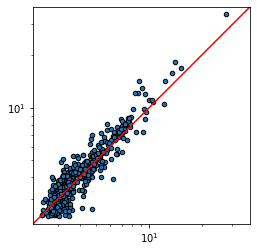

In [7]:

import matplotlib.pyplot as plt

lim = [min(*correct, *predictions)*.9, max(*correct, *predictions)*1.1]
plt.scatter(correct, predictions, s=20, linewidths=1, edgecolors='black')
# plt.scatter(correct, predictions, s=20)
plt.gca().set_aspect('equal')
plt.gca().set_xlim(lim)
plt.gca().set_ylim(lim)
plt.xscale('log')
plt.yscale('log')
plt.plot(lim, lim, color='red')
plt.show()

In [8]:
torch.save(model.state_dict(), "PLD_CNN_150_epochs_2-2-23_2.pt")